<a href="https://colab.research.google.com/github/Yiping07/New/blob/master/lab3_part_II.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CS904 Part III (Computational Pathology)**

## Lab 3 - II: Epithelium Segmentation in histology images

This lab explains how to train a deep learning algorithm for epithelium segmentation. The identification of epithelium and stroma regions is important since regions of cancer are typically manifested in the epithelium. Histologic patterns within the stroma might be critical in predicting overall survival and outcome in breast cancer patients. Thus from the perspective of developing algorithms for predicting prognosis of disease, the epithelium-stroma separation becomes critical.


# **Download Required Code files and Dataset**

In [ ]:
# Following code will download the code files and dataset required for this demo.

import urllib.request
from tqdm import tqdm
from zipfile import ZipFile

code_url = 'https://bit.ly/2tvpRZw'
data_url = 'https://warwick.ac.uk/fac/sci/dcs/research/tia/data/pathlake_jan2020mcs_data.zip'

class DownloadProgressBar(tqdm):
    def update_to(self, b=1, bsize=1, tsize=None):
        if tsize is not None:
            self.total = tsize
        self.update(b * bsize - self.n)
       
with DownloadProgressBar(unit='B', unit_scale=True, miniters=1, desc='code.zip') as t:
  urllib.request.urlretrieve(code_url, filename='code.zip', reporthook=t.update_to)
with DownloadProgressBar(unit='B', unit_scale=True, miniters=1, desc='data.zip') as t:
  urllib.request.urlretrieve(data_url, filename='data.zip', reporthook=t.update_to)

# Create a ZipFile Object and load models.zip in it
with ZipFile('data.zip', 'r') as zipObj:
  #  Extract all the contents of zip file in current directory
   zipObj.extractall()
# Create a ZipFile Object ando load images.zip in it
with ZipFile('code.zip', 'r') as zipObj:
   # Extract all the contents of zip file in current directory
   zipObj.extractall() 

print('Required code files and data has been downloaded successfully.')
print('\nPlease run next section to see the file hierarchy.')


code.zip: 16.4kB [00:01, 11.2kB/s]                            
data.zip: 353MB [00:50, 7.04MB/s]                           


Required code files and data has been downloaded successfully.

Please run next section to see the file hierarchy.


In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms
import tables
import os
import sys
import glob
import PIL
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn import model_selection
import sklearn.feature_extraction.image
import random
from unet import UNet #code borrowed from https://github.com/jvanvugt/pytorch-unet
import scipy.ndimage 
import time
import math
import tables
import random
from sklearn.metrics import confusion_matrix
from skimage import io, morphology

seed = random.randrange(sys.maxsize) #get a random seed so that we can reproducibly do the cross validation setup
random.seed(seed) # set the seed
print(f"random seed (note down for reproducibility): {seed}")

random seed (note down for reproducibility): 3676253114603798117


# **HDF5 File Generation**

In [ ]:
dataname = "epistroma"

# --- pytables params
patch_size = 500 # size of the tiles to extract and save in the database, must be >= to training size
stride_size = 250 # distance to skip between patches, 1 indicated pixel wise extraction, 
                  # patch_size would result in non-overlapping tiles
mirror_pad_size = 250 # number of pixels to pad *after* resize to image with by mirroring 
                      # (edge's of patches tend not to be analyzed well, so padding allows them to appear more centered in the patch)
test_set_size =.2 # what percentage of the dataset should be used as a held out validation/testing set 80-20 split
resize = 1 # resize input images
classes = [0,1] # what classes we expect to have in the data, here we have only 
                # 2 classes but we could add additional classes and/or specify an index from which we would like to ignore

ignore_index = -100 # Unet has the possibility of masking out pixels in 
                    # the output image, we can specify the index value here (though not used)
gpuid = 0

# --- unet params
# these parameters get fed directly into the UNET class, and more description of them can be discovered there
n_classes = 2    #number of classes in the data mask that we'll aim to predict
in_channels = 3  #input channel of the data, RGB = 3
padding = True   #should levels be padded
depth = 5      # depth of the network -- default of 5 for unet

wf= 2           #wf (int): number of filters in the first layer is 2**wf, was 6
up_mode= 'upconv' #should we simply upsample the mask, or should we try and learn an interpolation 
batch_norm = True #should we use batch normalization between the layers

# --- training params
batch_size = 128
patch_size = 256
num_epochs = 50 #  run it for 100 if you like
edge_weight = 1.1 # edges tend to be the most poorly segmented given how little area they 
                  # occupy in the training set, this paramter boosts their values along the lines of the original UNET paper
phases = ["train","val"] # how many phases did we create databases for?
validation_phases= ["val"] # when should we do valiation? note that validation is time consuming, @@@@@@Max: Can add train here as well
                           # so as opposed to doing for both training and validation, we do it only for vlaidation at the end of the epoch

img_dtype = tables.UInt8Atom()  # dtype in which the images will be saved, this indicates 
                                # that images will be saved as unsigned int 8 bit, i.e., [0,255]
filenameAtom = tables.StringAtom(itemsize=255) #create an atom to store the filename of the image, just incase we need it later, 

files = glob.glob('data/masks/*.png') # create a list of the files, in this case we're only   
                              # interested in files which have masks so we can use supervised learning

# do this to speed things up!
files=files[0:5] # take only first 5 files for training

print(files)
# create training and validation stages and split the files appropriately between them
phases = {}
phases["train"],phases["val"] = next(iter(model_selection.ShuffleSplit(n_splits=1,test_size=test_set_size).split(files)))

# specify that we'll be saving 2 different image types to the database, an image and its associated masked
imgtypes = ["img","mask"]

['data/masks/9346_00019_mask.png', 'data/masks/12867_00005_mask.png', 'data/masks/9023_00012_mask.png', 'data/masks/12932_00003_mask.png', 'data/masks/12819_00004_mask.png']


In [ ]:
storage = {} # holder for future pytables

block_shape = {} # block shape specifies what we'll be saving into the pytable array, here we assume that masks are 1d and images are 3d
block_shape["img"]= np.array((patch_size,patch_size,3))
block_shape["mask"]= np.array((patch_size,patch_size)) 

filters=tables.Filters(complevel=6, complib='zlib') #we can also specify filters, such as compression, to improve storage speed


for phase in phases.keys(): #now for each of the phases, we'll loop through the files
    print(phase)
    
    totals=np.zeros((2,len(classes))) # we can to keep counts of all the classes in for in particular training, since we 
    totals[0,:] = classes               # can later use this information to create better weights

    hdf5_file = tables.open_file( f"{dataname}_{phase}.pytable", mode='w') # open the respective pytable relative to current working_dir
    storage["filename"] = hdf5_file.create_earray(hdf5_file.root, 'filename', filenameAtom, (0,)) #create the array for storage
    
    for imgtype in imgtypes: #for each of the image types, in this case mask and image, we need to create the associated earray
        storage[imgtype] = hdf5_file.create_earray(hdf5_file.root, imgtype, img_dtype,  
                                                  shape=np.append([0],block_shape[imgtype]), 
                                                  chunkshape=np.append([1],block_shape[imgtype]),
                                                  filters=filters)
    
    for filei in phases[phase]: #now for each of the files
        fname = files[filei] 
        
        print(fname)
        for imgtype in imgtypes:
            if( imgtype=="img"): # if we're looking at an img, it must be 3 channel, but cv2 won't load 
                                 # it in the correct channel order, so we need to fix that
                io=cv2.cvtColor(cv2.imread('data/imgs/'+os.path.basename(fname).replace("_mask.png",".tif")), cv2.COLOR_BGR2RGB)
                interp_method=PIL.Image.BICUBIC
                
            else: #if its a mask image, then we only need a single channel (since grayscale 3D images are equal in all channels)
                io = cv2.imread(fname) # the image is loaded as {0,255}, 
                          # but we'd like to store it as {0,1} since this represents the binary nature of the mask easier
                io[io > 1] = 1
                interp_method = PIL.Image.NEAREST #want to use nearest! otherwise resizing 
                          # may cause non-existing classes to be produced via interpolation (e.g., ".25")
                
                for i,key in enumerate(classes): # sum the number of pixels, this is done pre-resize, 
                                                 # the but proportions don't change which is really what we're after
                    totals[1,i] += sum(sum(io[:,:,0]==key))

            
            io = cv2.resize(io,(0,0),fx=resize,fy=resize, interpolation=interp_method) #resize it as specified above
            io = np.pad(io, [(mirror_pad_size, mirror_pad_size), (mirror_pad_size, mirror_pad_size), (0, 0)], mode="reflect")

            #convert input image into overlapping tiles, size is ntiler x ntilec x 1 x patch_size x patch_size x3
            io_arr_out = sklearn.feature_extraction.image.extract_patches(io,(patch_size,patch_size,3),stride_size)
            
            #resize it into a ntile x patch_size x patch_size x 3
            io_arr_out = io_arr_out.reshape(-1,patch_size,patch_size,3)
            
            
            
            #save the 4D tensor to the table
            if(imgtype=="img"):
                storage[imgtype].append(io_arr_out)
            else:
                storage[imgtype].append(io_arr_out[:,:,:,0].squeeze()) #only need 1 channel for mask data

        storage["filename"].append([fname for x in range(io_arr_out.shape[0])]) #add the filename to the storage array
        
    #lastely, we should store the number of pixels
    npixels=hdf5_file.create_carray(hdf5_file.root, 'numpixels', tables.Atom.from_dtype(totals.dtype), totals.shape)
    npixels[:]=totals
    hdf5_file.close()

train
data/masks/9346_00019_mask.png
data/masks/12819_00004_mask.png


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function extract_patches is deprecated; The function feature_extraction.image.extract_patches has been deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(msg, category=FutureWarning)


data/masks/12932_00003_mask.png
data/masks/9023_00012_mask.png
val
data/masks/12867_00005_mask.png


# **Training of UNET based Segmentation Model**

In [ ]:
#helper function for pretty printing of current time and remaining time
def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)
def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent+.00001)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [ ]:
#specify if we should use a GPU (cuda) or only the CPU
if(torch.cuda.is_available()):
    print(torch.cuda.get_device_properties(gpuid))
    torch.cuda.set_device(gpuid)
    device = torch.device(f'cuda:{gpuid}')
else:
    device = torch.device(f'cpu')
    
print(device)

_CudaDeviceProperties(name='Tesla P4', major=6, minor=1, total_memory=7611MB, multi_processor_count=20)
cuda:0


In [ ]:
#build the model according to the paramters specified above and copy it to the GPU. finally print out the number of trainable parameters
model = UNet(n_classes=n_classes, 
             in_channels=in_channels, 
             padding=padding,depth=depth,
             wf=wf, up_mode=up_mode, 
             batch_norm=batch_norm).to(device)
print(f"total params: \t{sum([np.prod(p.size()) for p in model.parameters()])}")

total params: 	122466


In [ ]:
#this defines our dataset class which will be used by the dataloader
class Dataset(object):
    def __init__(self, fname ,img_transform=None, mask_transform = None, edge_weight= False):
        #nothing special here, just internalizing the constructor parameters
        self.fname=fname
        self.edge_weight = edge_weight
        
        self.img_transform=img_transform
        self.mask_transform = mask_transform
        
        self.tables=tables.open_file(self.fname)
        self.numpixels=self.tables.root.numpixels[:]
        self.nitems=self.tables.root.img.shape[0]
        self.tables.close()
        
        self.img = None
        self.mask = None
        
    def __getitem__(self, index):
        # opening should be done in __init__ but seems to be
        # an issue with multithreading so doing here
        with tables.open_file(self.fname,'r') as db:
            self.img=db.root.img
            self.mask=db.root.mask
       
            #get the requested image and mask from the pytable
            img = self.img[index,:,:,:]
            mask = self.mask[index,:,:]
        
        # the original Unet paper assignes increased weights to the edges of the annotated objects
        # their method is more sophistocated, but this one is faster, we simply dilate the mask and 
        # highlight all the pixels which were "added"
        if(self.edge_weight):
            weight = scipy.ndimage.morphology.binary_dilation(mask==1, iterations =2) & ~mask
        else: # otherwise the edge weight is all ones and thus has no affect
            weight = np.ones(mask.shape,dtype=mask.dtype)
        
        mask = mask[:,:,None].repeat(3,axis=2) # in order to use the transformations given by torchvision
        weight = weight[:,:,None].repeat(3,axis=2) # inputs need to be 3D, so here we convert from 1d to 3d by repetition
        
        img_new = img
        mask_new = mask
        weight_new = weight
        
        seed = random.randrange(sys.maxsize) #get a random seed so that we can reproducibly do the transofrmations
        if self.img_transform is not None:
            random.seed(seed) # apply this seed to img transforms
            img_new = self.img_transform(img)

        if self.mask_transform is not None:
            random.seed(seed)
            mask_new = self.mask_transform(mask)
            mask_new = np.asarray(mask_new)[:,:,0].squeeze()
            
            random.seed(seed)
            weight_new = self.mask_transform(weight)
            weight_new = np.asarray(weight_new)[:,:,0].squeeze()

        return img_new, mask_new, weight_new
    def __len__(self):
        return self.nitems

In [ ]:
#note that since we need the transofrmations to be reproducible for both masks and images
#we do the spatial transformations first, and afterwards do any color augmentations
img_transform = transforms.Compose([
     transforms.ToPILImage(),
    transforms.RandomVerticalFlip(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(size=(patch_size,patch_size),pad_if_needed=True), 
      # these need to be in a reproducible order, first affine transforms and then color
    transforms.RandomResizedCrop(size=patch_size),
    transforms.RandomRotation(180),
    transforms.ColorJitter(brightness=0, contrast=0, saturation=0, hue=.5),
    transforms.RandomGrayscale(),
    transforms.ToTensor()
    ])


mask_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomVerticalFlip(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(size=(patch_size,patch_size),pad_if_needed=True), 
        # these need to be in a reproducible order, first affine transforms and then color
    transforms.RandomResizedCrop(size=patch_size,interpolation=PIL.Image.NEAREST),
    transforms.RandomRotation(180),
    ])


dataset={}
dataLoader={}
for phase in phases: #now for each of the phases, we're creating the dataloader
                     #interestingly, given the batch size, i've not seen any improvements from using a num_workers>0
    
    dataset[phase] = Dataset(f"./{dataname}_{phase}.pytable", 
                             img_transform=img_transform, 
                             mask_transform = mask_transform,
                             edge_weight=edge_weight)
    dataLoader[phase] = DataLoader(dataset[phase], batch_size=batch_size, 
                                shuffle=True, num_workers=0, pin_memory=True) 


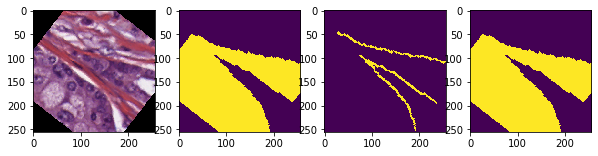

In [ ]:
#visualize a single example to verify that it is correct
(img,patch_mask,patch_mask_weight)=dataset["train"][3]
fig, ax = plt.subplots(1,4, figsize=(10,4))  # 1 row, 2 columns

#build output showing original patch  (after augmentation), class = 1 mask, weighting mask, overall mask (to see any ignored classes)
ax[0].imshow(np.moveaxis(img.numpy(),0,-1))
ax[1].imshow(patch_mask==1)
ax[2].imshow(patch_mask_weight)
ax[3].imshow(patch_mask)

In [ ]:
optim = torch.optim.Adam(model.parameters()) # Adam is going to be the most robust

In [ ]:
#we have the ability to weight individual classes, in this case we'll do so based on their presense in the trainingset
#to avoid biasing any particular class
nclasses = dataset["train"].numpixels.shape[1]
class_weight = dataset["train"].numpixels[1,0:2] #don't take ignored class into account here
class_weight = torch.from_numpy(1-class_weight/class_weight.sum()).type('torch.FloatTensor').to(device)

print(class_weight) # show final used weights, make sure that they're reasonable before continouing
criterion = nn.CrossEntropyLoss(weight = class_weight, ignore_index = ignore_index, reduce=False)
               # reduce = False makes sure we get a 2D output instead of a 1D "summary" value

tensor([0.4061, 0.5939], device='cuda:0')


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


In [ ]:

best_loss_on_test = np.Infinity
edge_weight = torch.tensor(edge_weight).to(device)
start_time = time.time()
for epoch in range(num_epochs):
    #zero out epoch based performance variables 
    all_acc = {key: 0 for key in phases} 
    all_loss = {key: torch.zeros(0).to(device) for key in phases}
    cmatrix = {key: np.zeros((2,2)) for key in phases}

    for phase in phases: #iterate through both training and validation states

        if phase == 'train':
            model.train()  # Set model to training mode
        else: #when in eval mode, we don't want parameters to be updated
            model.eval()   # Set model to evaluate mode

        for ii , (X, y, y_weight) in enumerate(dataLoader[phase]): #for each of the batches
            X = X.to(device)  # [Nbatch, 3, H, W]
            y_weight = y_weight.type('torch.FloatTensor').to(device)
            y = y.type('torch.LongTensor').to(device)  # [Nbatch, H, W] with class indices (0, 1)

            with torch.set_grad_enabled(phase == 'train'): 
                          # dynamically set gradient computation, in case of validation, this isn't needed
                          # disabling is good practice and improves inference time

                prediction = model(X)  # [N, Nclass, H, W]
                loss_matrix = criterion(prediction, y)
                loss = (loss_matrix * (edge_weight**y_weight)).mean() #can skip if edge weight==1

                if phase=="train": #in case we're in train mode, need to do back propogation
                    optim.zero_grad()
                    loss.backward()
                    optim.step()
                    train_loss = loss


                all_loss[phase]=torch.cat((all_loss[phase],loss.detach().view(1,-1)))

                if phase in validation_phases: #if this phase is part of validation, compute confusion matrix
                    p=prediction[:,:,:,:].detach().cpu().numpy()
                    cpredflat=np.argmax(p,axis=1).flatten()
                    yflat=y.cpu().numpy().flatten()

                    cmatrix[phase]=cmatrix[phase]+confusion_matrix(yflat,cpredflat,labels=range(n_classes))

        all_acc[phase]=(cmatrix[phase]/cmatrix[phase].sum()).trace()
        all_loss[phase] = all_loss[phase].cpu().numpy().mean()


    print('%s ([%d/%d] %d%%), train loss: %.4f test loss: %.4f' \
              % (timeSince(start_time, (epoch+1) / num_epochs), 
              epoch+1, num_epochs ,(epoch+1) / num_epochs * 100, all_loss["train"], all_loss["val"]),end="")    

    #if current loss is the best we've seen, save model state with all variables
    #necessary for recreation
    if all_loss["val"] < best_loss_on_test:
        best_loss_on_test = all_loss["val"]
        print("  **")
        state = {'epoch': epoch + 1,
         'model_dict': model.state_dict(),
         'optim_dict': optim.state_dict(),
         'best_loss_on_test': all_loss,
         'n_classes': n_classes,
         'in_channels': in_channels,
         'padding': padding,
         'depth': depth,
         'wf': wf,
         'up_mode': up_mode, 'batch_norm': batch_norm}


        torch.save(state, f"{dataname}_unet_best_model.pth") # saves to current working directory
    else:
        print("")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in true_divide


0m 3s (- 3m 4s) ([1/50] 2%), train loss: 0.4516 test loss: 0.3345  **
0m 7s (- 2m 57s) ([2/50] 4%), train loss: 0.4333 test loss: 0.3327  **
0m 10s (- 2m 52s) ([3/50] 6%), train loss: 0.4228 test loss: 0.3364
0m 14s (- 2m 48s) ([4/50] 8%), train loss: 0.4138 test loss: 0.3377
0m 18s (- 2m 44s) ([5/50] 10%), train loss: 0.4067 test loss: 0.3367
0m 21s (- 2m 40s) ([6/50] 12%), train loss: 0.3965 test loss: 0.3340
0m 25s (- 2m 36s) ([7/50] 14%), train loss: 0.3838 test loss: 0.3323  **
0m 29s (- 2m 32s) ([8/50] 16%), train loss: 0.3820 test loss: 0.3302  **
0m 32s (- 2m 29s) ([9/50] 18%), train loss: 0.3698 test loss: 0.3307
0m 36s (- 2m 25s) ([10/50] 20%), train loss: 0.3717 test loss: 0.3304
0m 40s (- 2m 21s) ([11/50] 22%), train loss: 0.3706 test loss: 0.3333
0m 43s (- 2m 18s) ([12/50] 24%), train loss: 0.3675 test loss: 0.3297  **
0m 47s (- 2m 14s) ([13/50] 26%), train loss: 0.3710 test loss: 0.3305
0m 50s (- 2m 11s) ([14/50] 28%), train loss: 0.3602 test loss: 0.3340
0m 54s (- 2m 7s)

In [ ]:
#At this stage, training is done...below are snippets to help with other tasks: output generation + visualization 

In [ ]:
#----- generate output
#load best model
checkpoint = torch.load(f"{dataname}_unet_best_model.pth") # load best model from current working directory
model.load_state_dict(checkpoint["model_dict"])

<All keys matched successfully>

In [ ]:
#grab a single image from validation set
[img,mask,mask_weight]=dataset["val"][5]

In [ ]:
#generate its output
#%%timeit
output=model(img[None,::].to(device))
output=output.detach().squeeze().cpu().numpy()
output=np.moveaxis(output,0,-1) 
output.shape

(256, 256, 2)

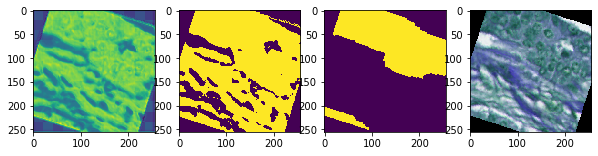

In [ ]:
#visualize its result
fig, ax = plt.subplots(1,4, figsize=(10,4))  # 1 row, 2 columns

ax[0].imshow(output[:,:,1])
ax[1].imshow(np.argmax(output,axis=2))
ax[2].imshow(mask)
ax[3].imshow(np.moveaxis(img.numpy(),0,-1))

In [ ]:
#------- visualize kernels and activations

# **Visulization of Validation Results**

In [ ]:

batch_size = 1 # nicer to have a single batch so that we can iterately 
               # view the output, while not consuming too much 
edge_weight = 1

In [ ]:
# note that since we need the transofrmations to be reproducible for both masks and images
# we do the spatial transformations first, and afterwards do any color augmentations

# in the case of using this for output generation, we want to use the original 
# images since they will give a better sense of the exepected 
# output when used on the rest of the dataset, as a result, we disable all unnecessary augmentation.
# the only component that remains here is the randomcrop, to ensure that regardless of the size of the image
# in the database, we extract an appropriately sized patch
img_transform = transforms.Compose([
     transforms.ToPILImage(),
    transforms.RandomCrop(size=(patch_size,patch_size),pad_if_needed=True),
    transforms.ToTensor()
    ])


mask_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomCrop(size=(patch_size,patch_size),pad_if_needed=True), 
    ])

phases=["val"]
dataset={}
dataLoader={}
for phase in phases:
    
    dataset[phase]=Dataset( f"./{dataname}_{phase}.pytable", # load from working directory
                           img_transform=img_transform, 
                           mask_transform = mask_transform,
                           edge_weight=edge_weight)
    dataLoader[phase]=DataLoader(dataset[phase], batch_size=batch_size, 
                                shuffle=True, num_workers=0, pin_memory=True) #,pin_memory=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


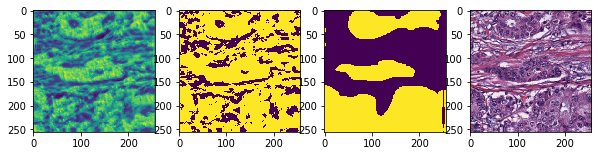

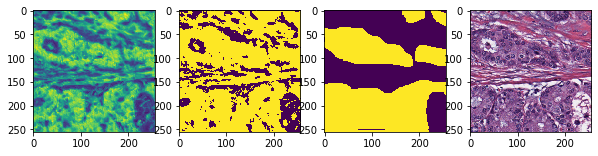

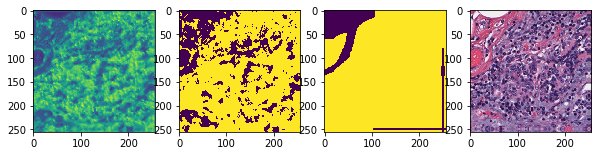

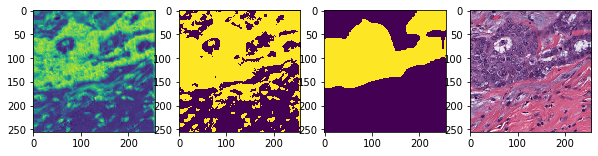

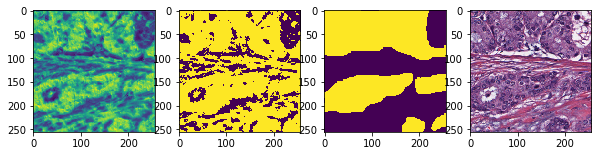

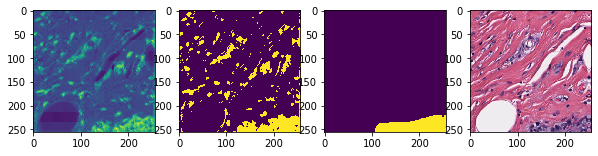

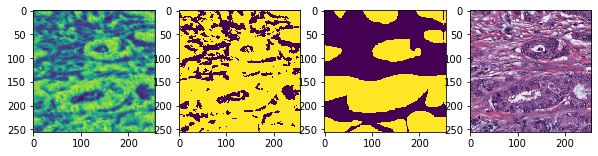

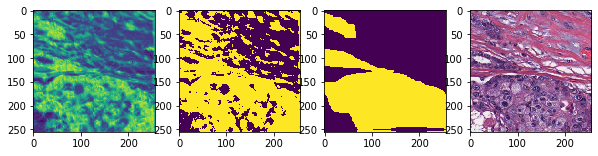

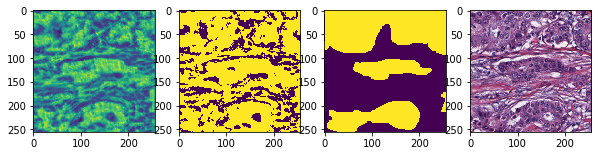

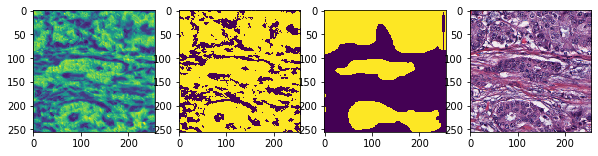

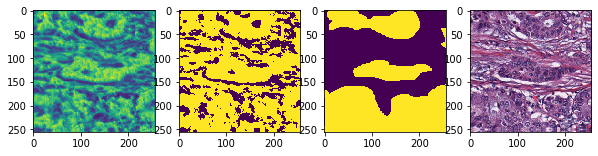

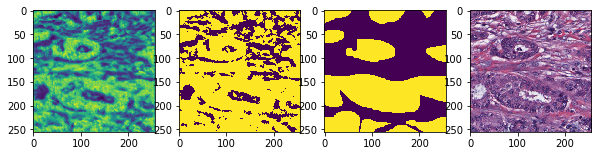

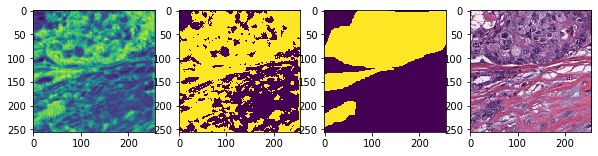

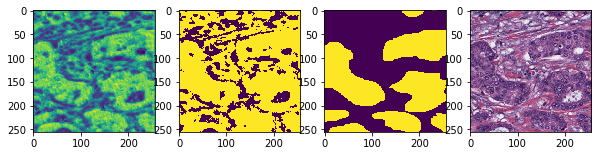

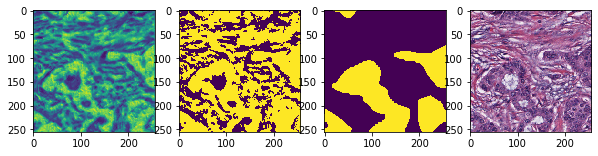

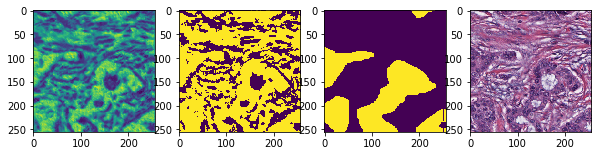

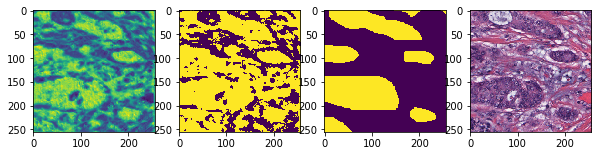

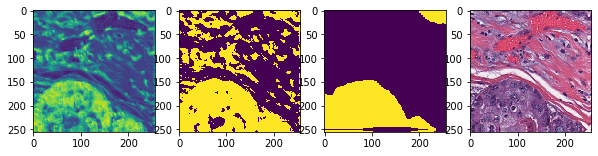

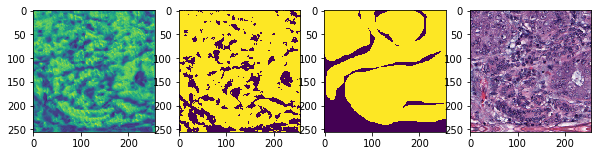

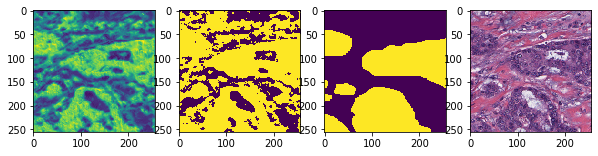

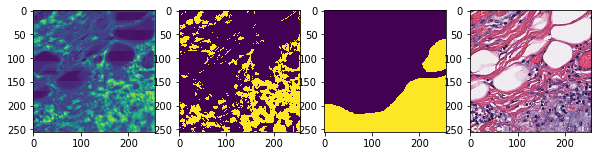

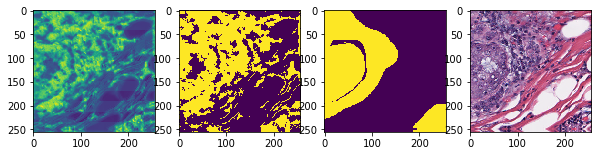

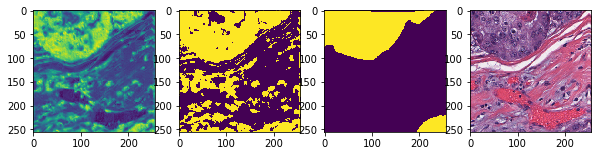

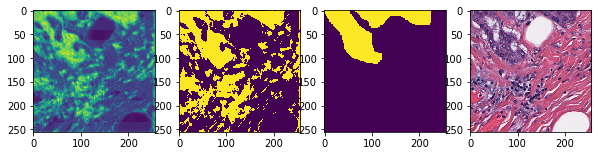

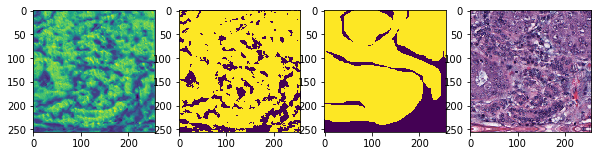

In [ ]:
%matplotlib inline

#set the model to evaluation mode, since we're only generating output and not doing any back propogation
model.eval()
for ii , (X, y, y_weight) in enumerate(dataLoader["val"]):
    X = X.to(device)  # [NBATCH, 3, H, W]
    y = y.type('torch.LongTensor').to(device)  # [NBATCH, H, W] with class indices (0, 1)

    output = model(X)  # [NBATCH, 2, H, W]

    output=output.detach().squeeze().cpu().numpy() #get output and pull it to CPU
    output=np.moveaxis(output,0,-1)  #reshape moving last dimension
    
    fig, ax = plt.subplots(1,4, figsize=(10,4))  # 1 row, 2 columns

    ax[0].imshow(output[:,:,1])
    ax[1].imshow(np.argmax(output,axis=2))
    ax[2].imshow(y.detach().squeeze().cpu().numpy())
    ax[3].imshow(np.moveaxis(X.detach().squeeze().cpu().numpy(),0,-1))